### Advanced Machine Learning

# Final Assignment  - Detect True vs False Stories (lie detection)

Assignment Start: 11/07/21 00:00<br>
Assignment Due: 18/07/21 23:59 (moodle will be closed for submissions that time)

Jonathan Schler


In [1]:
id="323637736"
name="Alexander Kruglyak"

## Introduction
You are provided with a labeled corpus of narratives in Hebrew. The corpus is provided as a csv file. Each row represents a narrative. It has 5 fields: id, author_gender, author_birth_year, narrative and label. The label for each narrative indicates whether this is a true or false story (i.e. the author lied when he told the story) (label "1" for True, and "0" for false). 

You are requested to build a model to predict whether a new story in Hebrew is true or false (i.e a lie). You are provided with 2 files: 
- `train_dataset.csv` - which contains **labeled** examples, and 
- `test_dataset.csv` that contains **unlabled** examples that you'll have to classify and submit the results. The narrtives in this file will have the same fields except of the label field.

(you'll be graded based on the quality of the labels assigned to the `test_dataset.csv`).





## What is expected from you
1. Build a classifier (including all pre-processing steps - as you think may fit (feature engineering, pre-processing, scaling etc) ) that will classify an unlabled document (including reasonable documentation for the steps you chose to do)
2. Report on how you chose to evaluate your algorithm and the scores of that evaluation
3. Apply the model on the unlabeled data set (`test_dataset.csv`), and return the results in the format described below
4. At the end, you are requested to submit 2 files: (a) this notebook, and (b) the output csv file. Submission will be done via moodle. The output csv is the file, that contains the prediction for the `test_dataset.csv`. The naming of the file should be `<your_id_number>.csv` (where `<your_id_number>` will be replaced with you actual ID number). The file will contain for each doc a label `1` (for true narratives) or `0` (for false narratives) (such that each row contains only one label, corresponding to the document in the given row in the `test_dataset.csv` document). You can see a sample output file under the name `123456789.csv` in the moodle.

## Grading Guidelines
1. Overall approach and workable solution (70 pts)
2. Average f1 score of higher than 0.50 (10 pts)
3. Average f1 score of higher than 0.58 (additional 5 pts)
4. Competitive element: 15 Highest average f1 score - will get additional 15 pts, top score the extra 15 points, second highest - extra 14 points etc - in case of similar scores it will be divided proportionaly.

## Other Guidelines
1. Work in indivudual, collaboration is not allowed. 
2. You are allowed to use all the toolsets we learned / mentioned in class, in addition to any other avialble toolsets for text processing or Hebrew data as you think is appropriate.


## General imports

In [2]:
%pip install python-bidi

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, PassiveAggressiveClassifier, Perceptron, RidgeClassifier, RidgeClassifierCV, SGDClassifier
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score, GridSearchCV, cross_validate
from sklearn.preprocessing import normalize, StandardScaler, FunctionTransformer
from sklearn.linear_model import Ridge, LinearRegression, LogisticRegression, LogisticRegressionCV, Lasso, RidgeCV, LassoCV, ElasticNet
from sklearn.pipeline import Pipeline, FeatureUnion

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
from bidi import algorithm as bidialg


Note: you may need to restart the kernel to use updated packages.


### Useful util functions

In [3]:
def drop_columns(df, columns):
    return df.copy().drop(columns, axis=1)


def get_label_and_drop(_df):
    df = _df.copy()
    label = df['label']
    df = drop_columns(df,['label'])
    return df, label


def show_data_basic_information(df):
    print("Info\n")
    print(df.info())
    print("\n" + "*" * 10 + "\n")
    
    print("Shape\n")
    print(df.shape) 
    print("\n" + "*" * 10 + "\n")
    
    print("Amount of is null data\n")
    print(df.isnull().sum().max())
    print("\n" + "*" * 10 + "\n")
    
    print("Describe\n")
    display(df.describe())
    print("\n" + "*" * 10 + "\n")
    
    
def get_dummies(_df,columns_to_dummy):
    df = _df.copy()
    df = pd.get_dummies(df,columns=columns_to_dummy)
    return df

def translate_author_gender(_df):
    df = _df.copy()
    _df["author_gender"].replace(to_replace="זכר", value='male', inplace=True)
    _df["author_gender"].replace(to_replace="נקבה", value="female", inplace=True)
    return _df


def get_dummies(_df,columns_to_dummy):
    df = _df.copy()
    df = pd.get_dummies(df,columns=columns_to_dummy)
    return df

def translate_author_gender(_df):
    df = _df.copy()
    print(df.head())
    _df["author_gender"].replace(to_replace="זכר", value='male', inplace=True)
    _df["author_gender"].replace(to_replace="נקבה", value="female", inplace=True)
    return _df

def prepare_data(_df):
    df = _df.copy()
    return get_dummies(translate_author_gender(df), ["author_gender"])

def get_regressors():
    return [
    LogisticRegression(),
    LogisticRegressionCV(),
    PassiveAggressiveClassifier(),
    Perceptron(),
    RidgeClassifier(),
    RidgeClassifierCV(),
    SGDClassifier()
    ]

def show_random_text(_df,feature,n=1):
    df = _df.sample(n=n,random_state=42)
    print(list(df[feature]))

In [4]:
df_train = pd.read_csv("train_dataset.csv")
df_test = pd.read_csv("test_dataset.csv")

In [5]:
# https://github.com/gidim/HebrewStopWords
stop_words = [x.strip() for x in open('heb_stopwords.txt','r').read().split('\n')]

### Data exploration

In [6]:
df_train.head()

,Unnamed: 0,author_gender,author_birth_year,narrative,label
0,0,זכר,1995,"שנת 2020 הייתה מטלטלת למדי בשבילי, עברתי הרבה ...",1
1,1,זכר,1992,בשנת 2018 קיבלתי החלטה שאני מתחיל ללמוד לתואר ...,1
2,2,זכר,1992,לפני מספר שנים אני ובת הזוג שלי טסנו ללונדון ז...,1
3,3,נקבה,1991,"האישה שבקושי הכרתי חייכה תמיד, העיניים שלה ברק...",1
4,4,נקבה,1992,בדרך חזרה מהטיול שנתי בכיתה ח' התקשרתי לאבא של...,1


In [7]:
df_train.isna().sum()

Unnamed: 0           0
author_gender        0
author_birth_year    0
narrative            0
label                0
dtype: int64

In [8]:
show_data_basic_information(df_train)

Info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 408 entries, 0 to 407
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Unnamed: 0         408 non-null    int64 
 1   author_gender      408 non-null    object
 2   author_birth_year  408 non-null    int64 
 3   narrative          408 non-null    object
 4   label              408 non-null    int64 
dtypes: int64(3), object(2)
memory usage: 16.1+ KB
None

**********

Shape

(408, 5)

**********

Amount of is null data

0

**********

Describe



,Unnamed: 0,author_birth_year,label
count,408.000000,408.000000,408.000000
mean,203.500000,1993.573529,0.500000
std,117.923704,3.370560,0.500614
min,0.000000,1980.000000,0.000000
25%,101.750000,1992.750000,0.000000
50%,203.500000,1994.000000,0.500000
75%,305.250000,1995.000000,1.000000
max,407.000000,2002.000000,1.000000



**********



Text(0.5, 1.0, 'true VS false')

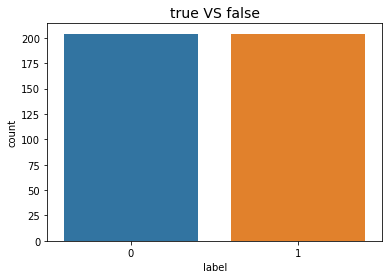

In [9]:
sns.countplot(x='label',data=df_train)
plt.title('true VS false', fontsize=14)

Data is balanced

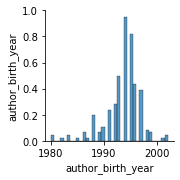

In [10]:
sns.pairplot(df_train[['author_birth_year']])

In [11]:
print(pd.Series(' '.join(df_train['narrative']).lower().split()).value_counts()[:20])

את       2642
לא       1866
של       1308
על       1202
היה      1126
עם       1086
לי       1017
אני       927
כל        925
שלי       903
זה        797
לאחר      638
מאוד      539
אבל       528
הוא       513
גם        496
מה        495
שאני      478
כי        465
הייתה     423
dtype: int64


### Data cleanup and enhancment

In [12]:
COLS_TO_DROP = ["Unnamed: 0"]

df_train = drop_columns(pd.read_csv("train_dataset.csv"), COLS_TO_DROP)
df_test = drop_columns(pd.read_csv("test_dataset.csv"), COLS_TO_DROP)

df_train = prepare_data(df_train)
df_test = prepare_data(df_test)

  author_gender  author_birth_year  \
0           זכר               1995   
1           זכר               1992   
2           זכר               1992   
3          נקבה               1991   
4          נקבה               1992   

                                           narrative  label  
0  שנת 2020 הייתה מטלטלת למדי בשבילי, עברתי הרבה ...      1  
1  בשנת 2018 קיבלתי החלטה שאני מתחיל ללמוד לתואר ...      1  
2  לפני מספר שנים אני ובת הזוג שלי טסנו ללונדון ז...      1  
3  האישה שבקושי הכרתי חייכה תמיד, העיניים שלה ברק...      1  
4  בדרך חזרה מהטיול שנתי בכיתה ח' התקשרתי לאבא של...      1  
  author_gender  author_birth_year  \
0           זכר               2002   
1          נקבה               1995   
2           זכר               1995   
3           זכר               1991   
4           זכר               1995   

                                           narrative  
0  זה התחיל בשעת השקיעה.הגענו לחוף מדרום לעין גדי...  
1  כזוג מאורס טרי סגרנו תאריך, אולם אירועים, ספקי...  
2  הג

In [13]:
df_train['narrative'][0]

'שנת 2020 הייתה מטלטלת למדי בשבילי, עברתי הרבה מאוד חוויות בה, בין אם הן חיוביות או לעומת זאת שליליות, חלקן היו בעלות אופי דו משמעי, כלומר לעיתים חיובי ולחילופין שלילי. אחת החוויות היותר משפיעות הייתה מעבר מוסד לימודים, אפשר לסייג אותה בתור חוויה חיובית באופן כללי אך כמו שספרתי קודם לכן היו בה רגעים פחות חיוביים ואפילו שליליים למדי.\nזה היה למעשה מעבר מאוניברסיטה נחשבת מאוד למכללה מקצועית לא פחות אך עם שם איך נאמר פחות מפורסם ופחות יוצא מן השורות הראשונות של הקידמה האדמית בארץ ובכלל בעולם.\nהמעבר הזה הכה חזק באגו ואף נגע בתדמית שלי, אפשר להגיד את זה בצורה ישירה ובדוקה שזו גם דעת הכלל על הפן המקצועי שלי.\nאני סובר שהחלק שהיה הכי משמעותי במכה הזאת הוא הציונים בקורסים השונים, כנראה שזה קרה כך כי מאחורי הקלעים אני הייתי מצפה להעלות את הציונים עקב הירידה בקושי האקדמי המשתמע מן השינוי אך זה לא קרה, שאלתי את עצמי מדוע זה כך פעמים רבות וטרם הבנתי את התשובה לכך.\nהלימודים במוסד החדש היו במתכונת רחוקה בלבד, למדתי שעות ורבות ואכן השקעתי את רוב כוחותיי במשימות והאתגרים, טוב, אם להיות כנה עד הסוף, 

In [14]:
df_train['narrative'] = df_train['narrative'].str.replace(r'\n', '')
df_test['narrative'] = df_test['narrative'].str.replace(r'\n', '')

In [15]:
df_train['narrative'][0]

'שנת 2020 הייתה מטלטלת למדי בשבילי, עברתי הרבה מאוד חוויות בה, בין אם הן חיוביות או לעומת זאת שליליות, חלקן היו בעלות אופי דו משמעי, כלומר לעיתים חיובי ולחילופין שלילי. אחת החוויות היותר משפיעות הייתה מעבר מוסד לימודים, אפשר לסייג אותה בתור חוויה חיובית באופן כללי אך כמו שספרתי קודם לכן היו בה רגעים פחות חיוביים ואפילו שליליים למדי.זה היה למעשה מעבר מאוניברסיטה נחשבת מאוד למכללה מקצועית לא פחות אך עם שם איך נאמר פחות מפורסם ופחות יוצא מן השורות הראשונות של הקידמה האדמית בארץ ובכלל בעולם.המעבר הזה הכה חזק באגו ואף נגע בתדמית שלי, אפשר להגיד את זה בצורה ישירה ובדוקה שזו גם דעת הכלל על הפן המקצועי שלי.אני סובר שהחלק שהיה הכי משמעותי במכה הזאת הוא הציונים בקורסים השונים, כנראה שזה קרה כך כי מאחורי הקלעים אני הייתי מצפה להעלות את הציונים עקב הירידה בקושי האקדמי המשתמע מן השינוי אך זה לא קרה, שאלתי את עצמי מדוע זה כך פעמים רבות וטרם הבנתי את התשובה לכך.הלימודים במוסד החדש היו במתכונת רחוקה בלבד, למדתי שעות ורבות ואכן השקעתי את רוב כוחותיי במשימות והאתגרים, טוב, אם להיות כנה עד הסוף, לאחר חשי

### CountVectorizer

In [16]:
text_trainval = df_train['narrative'].tolist()
y_trainval = df_train['label']

text_train, text_val, y_train, y_val = train_test_split(
    text_trainval, y_trainval, stratify=y_trainval, random_state=0)


vect = CountVectorizer(min_df=4)
X_train = vect.fit_transform(text_train)
X_val = vect.transform(text_val)

lr = LogisticRegression().fit(X_train, y_train)
print(len(vect.get_feature_names()))

lr.score(X_val, y_val)

3370


0.46078431372549017

In [17]:
X = df_train['narrative'].tolist()
Y = df_train['label']

vect = CountVectorizer(min_df=4)
X_train = vect.fit_transform(X)

lr = LogisticRegression(n_jobs=-1).fit(X_train, Y)

In [18]:
def add_score(scores_df, scores, regressorName, dataType):
    scores_df.loc[regressorName + '_' + dataType, 'f1'] = scores['test_f1'].mean()
    scores_df.loc[regressorName + '_' + dataType, 'recall'] = scores['test_recall'].mean()
    scores_df.loc[regressorName + '_' + dataType, 'roc_auc'] = scores['test_roc_auc'].mean()
    scores_df.loc[regressorName + '_' + dataType, 'average_precision'] = scores['test_average_precision'].mean()

def get_cross_val_score(scores_df,estimator,X_train,y_train,prefix="",sampler=None):
        name = estimator.__class__.__name__
        pipe = estimator
        sampler_name = ""
        if sampler is not None:
            pipe = make_imb_pipeline(sampler(random_state=42), estimator)
            sampler_name = sampler.__name__
        print('*********' + name + ' ' + sampler_name + '*********')
        score = cross_validate(
            pipe,
            X_train, 
            y_train, 
            cv=10,
            scoring=('roc_auc', 'average_precision', 'f1', 'recall'),
            n_jobs = -1
        )
        add_score(scores_df, score, name,prefix)
        
        
scores_df = pd.DataFrame(dtype=float)
        
for regr in get_regressors():
#     get_cross_val_score(scores_df,regr, X_train, y_train,"numerical")
    get_cross_val_score(scores_df,regr, X_train, Y,"CountVectorizer_without_stop_words")

*********LogisticRegression *********
*********LogisticRegressionCV *********
*********PassiveAggressiveClassifier *********
*********Perceptron *********
*********RidgeClassifier *********
*********RidgeClassifierCV *********
*********SGDClassifier *********


In [19]:
display(scores_df.sort_values(by="f1",ascending=False))

,f1,recall,roc_auc,average_precision
PassiveAggressiveClassifier_CountVectorizer_without_stop_words,0.524087,0.534524,0.556571,0.589701
RidgeClassifierCV_CountVectorizer_without_stop_words,0.520467,0.525238,0.549107,0.580901
LogisticRegression_CountVectorizer_without_stop_words,0.519545,0.529762,0.556702,0.582177
Perceptron_CountVectorizer_without_stop_words,0.518838,0.514048,0.555464,0.582665
SGDClassifier_CountVectorizer_without_stop_words,0.515375,0.515000,0.540583,0.564552
RidgeClassifier_CountVectorizer_without_stop_words,0.510698,0.510476,0.548893,0.578224
LogisticRegressionCV_CountVectorizer_without_stop_words,0.508263,0.500476,0.547893,0.586840


### CountVectorizer + stop words

In [20]:
vect = CountVectorizer(min_df=4, stop_words=stop_words)
X_train = vect.fit_transform(X)


for regr in get_regressors():
#     get_cross_val_score(scores_df,regr, X_train, y_train,"numerical")
    get_cross_val_score(scores_df,regr, X_train, Y, "CountVectorizer_with_stop_words")

*********LogisticRegression *********
*********LogisticRegressionCV *********
*********PassiveAggressiveClassifier *********
*********Perceptron *********
*********RidgeClassifier *********
*********RidgeClassifierCV *********
*********SGDClassifier *********


In [21]:
print(len(vect.get_feature_names()))

display(scores_df.sort_values(by="f1",ascending=False))

3931


,f1,recall,roc_auc,average_precision
SGDClassifier_CountVectorizer_with_stop_words,0.555021,0.573095,0.578226,0.612184
RidgeClassifier_CountVectorizer_with_stop_words,0.552907,0.559286,0.567810,0.604054
LogisticRegression_CountVectorizer_with_stop_words,0.548916,0.554048,0.587702,0.615188
LogisticRegressionCV_CountVectorizer_with_stop_words,0.547085,0.540000,0.620762,0.628137
PassiveAggressiveClassifier_CountVectorizer_with_stop_words,0.545304,0.549286,0.574131,0.602951
RidgeClassifierCV_CountVectorizer_with_stop_words,0.535141,0.534524,0.580036,0.601033
Perceptron_CountVectorizer_with_stop_words,0.526040,0.518571,0.569280,0.594208
PassiveAggressiveClassifier_CountVectorizer_without_stop_words,0.524087,0.534524,0.556571,0.589701
RidgeClassifierCV_CountVectorizer_without_stop_words,0.520467,0.525238,0.549107,0.580901
LogisticRegression_CountVectorizer_without_stop_words,0.519545,0.529762,0.556702,0.582177


### TfidfVectorizer

In [22]:
X = df_train['narrative'].tolist()


tdif = TfidfVectorizer(stop_words=stop_words,min_df=4)
X_train = tdif.fit_transform(X)

for regr in get_regressors():
    get_cross_val_score(scores_df,regr, X_train, Y,"TfidfVectorizer")

*********LogisticRegression *********
*********LogisticRegressionCV *********
*********PassiveAggressiveClassifier *********
*********Perceptron *********
*********RidgeClassifier *********
*********RidgeClassifierCV *********
*********SGDClassifier *********


In [23]:
display(scores_df.sort_values(by="f1",ascending=False))

,f1,recall,roc_auc,average_precision
SGDClassifier_CountVectorizer_with_stop_words,0.555021,0.573095,0.578226,0.612184
RidgeClassifier_CountVectorizer_with_stop_words,0.552907,0.559286,0.567810,0.604054
RidgeClassifierCV_TfidfVectorizer,0.551767,0.553810,0.611321,0.625770
LogisticRegression_TfidfVectorizer,0.549880,0.558571,0.604417,0.622868
LogisticRegression_CountVectorizer_with_stop_words,0.548916,0.554048,0.587702,0.615188
LogisticRegressionCV_CountVectorizer_with_stop_words,0.547085,0.540000,0.620762,0.628137
PassiveAggressiveClassifier_CountVectorizer_with_stop_words,0.545304,0.549286,0.574131,0.602951
RidgeClassifier_TfidfVectorizer,0.545005,0.554048,0.597917,0.623070
LogisticRegressionCV_TfidfVectorizer,0.541599,0.544286,0.593131,0.603136
SGDClassifier_TfidfVectorizer,0.535396,0.525476,0.579393,0.600416


### CountVectorizer + stop words + normalize

In [24]:
vect = CountVectorizer(min_df=4, stop_words=stop_words)

X_train = vect.fit_transform(X)
X_train = normalize(X_train,norm="l1")

for regr in get_regressors():
#     get_cross_val_score(scores_df,regr, X_train, y_train,"numerical")
    get_cross_val_score(scores_df,regr, X_train, Y, "CountVectorizer_normalized")

*********LogisticRegression *********
*********LogisticRegressionCV *********
*********PassiveAggressiveClassifier *********
*********Perceptron *********
*********RidgeClassifier *********
*********RidgeClassifierCV *********
*********SGDClassifier *********


In [25]:
display(scores_df.sort_values(by="f1",ascending=False))

,f1,recall,roc_auc,average_precision
SGDClassifier_CountVectorizer_normalized,0.626824,0.706905,0.624131,0.639467
LogisticRegressionCV_CountVectorizer_normalized,0.593541,0.597857,0.617690,0.641610
RidgeClassifierCV_CountVectorizer_normalized,0.590940,0.602619,0.620905,0.640249
Perceptron_CountVectorizer_normalized,0.583113,0.627857,0.570869,0.591285
RidgeClassifier_CountVectorizer_normalized,0.572579,0.580952,0.623631,0.638743
SGDClassifier_CountVectorizer_with_stop_words,0.555021,0.573095,0.578226,0.612184
RidgeClassifier_CountVectorizer_with_stop_words,0.552907,0.559286,0.567810,0.604054
RidgeClassifierCV_TfidfVectorizer,0.551767,0.553810,0.611321,0.625770
PassiveAggressiveClassifier_CountVectorizer_normalized,0.550146,0.559048,0.603714,0.633447
LogisticRegression_TfidfVectorizer,0.549880,0.558571,0.604417,0.622868


### TfidfVectorizer

In [26]:
X = df_train['narrative'].tolist()

tdif = TfidfVectorizer(stop_words=stop_words,min_df=4)
X_train = tdif.fit_transform(X)
X_train = normalize(X_train,norm="l1")

for regr in get_regressors():
    get_cross_val_score(scores_df,regr, X_train, Y,"TfidfVectorizer_normalized")

*********LogisticRegression *********
*********LogisticRegressionCV *********
*********PassiveAggressiveClassifier *********
*********Perceptron *********
*********RidgeClassifier *********
*********RidgeClassifierCV *********
*********SGDClassifier *********


In [27]:
display(scores_df.sort_values(by="f1",ascending=False))

,f1,recall,roc_auc,average_precision
SGDClassifier_TfidfVectorizer_normalized,0.629095,0.757619,0.620095,0.639043
SGDClassifier_CountVectorizer_normalized,0.626824,0.706905,0.624131,0.639467
LogisticRegressionCV_CountVectorizer_normalized,0.593541,0.597857,0.617690,0.641610
RidgeClassifierCV_CountVectorizer_normalized,0.590940,0.602619,0.620905,0.640249
Perceptron_CountVectorizer_normalized,0.583113,0.627857,0.570869,0.591285
Perceptron_TfidfVectorizer_normalized,0.576685,0.583095,0.585607,0.620991
RidgeClassifier_CountVectorizer_normalized,0.572579,0.580952,0.623631,0.638743
RidgeClassifierCV_TfidfVectorizer_normalized,0.569085,0.578333,0.617119,0.634616
SGDClassifier_CountVectorizer_with_stop_words,0.555021,0.573095,0.578226,0.612184
LogisticRegressionCV_TfidfVectorizer_normalized,0.554672,0.559048,0.604595,0.620404


### ngrams

In [28]:
X = df_train['narrative'].tolist()

ngrm = CountVectorizer(min_df=4, stop_words=stop_words, ngram_range=(1, 3))
X_train = ngrm.fit_transform(X)

for regr in get_regressors():
    get_cross_val_score(scores_df,regr, X_train, Y,"CountVectorizer_ngram")

*********LogisticRegression *********
*********LogisticRegressionCV *********
*********PassiveAggressiveClassifier *********
*********Perceptron *********
*********RidgeClassifier *********
*********RidgeClassifierCV *********
*********SGDClassifier *********


In [29]:
display(scores_df.sort_values(by="f1",ascending=False))

,f1,recall,roc_auc,average_precision
SGDClassifier_TfidfVectorizer_normalized,0.629095,0.757619,0.620095,0.639043
SGDClassifier_CountVectorizer_normalized,0.626824,0.706905,0.624131,0.639467
LogisticRegressionCV_CountVectorizer_normalized,0.593541,0.597857,0.617690,0.641610
RidgeClassifierCV_CountVectorizer_normalized,0.590940,0.602619,0.620905,0.640249
Perceptron_CountVectorizer_normalized,0.583113,0.627857,0.570869,0.591285
Perceptron_TfidfVectorizer_normalized,0.576685,0.583095,0.585607,0.620991
RidgeClassifier_CountVectorizer_normalized,0.572579,0.580952,0.623631,0.638743
RidgeClassifierCV_TfidfVectorizer_normalized,0.569085,0.578333,0.617119,0.634616
SGDClassifier_CountVectorizer_ngram,0.564293,0.579048,0.586167,0.605243
RidgeClassifier_CountVectorizer_ngram,0.558143,0.564286,0.571179,0.595036


### ngrams + normalize

In [50]:
X = df_train['narrative'].tolist()
ngrm = CountVectorizer(min_df=4, stop_words=stop_words, ngram_range=(1, 3))
X_train = ngrm.fit_transform(X)
X_train = normalize(X_train,norm="l1")

for regr in get_regressors():
    get_cross_val_score(scores_df,regr, X_train, Y,"CountVectorizer_ngram_normalize")



*********LogisticRegression *********
*********LogisticRegressionCV *********
*********PassiveAggressiveClassifier *********
*********Perceptron *********
*********RidgeClassifier *********
*********RidgeClassifierCV *********
*********SGDClassifier *********


In [51]:
display(scores_df.sort_values(by="f1",ascending=False))

,f1,recall,roc_auc,average_precision
SGDClassifier_CountVectorizer_ngram_normalize,0.642833,0.756190,0.622952,0.637711
Perceptron_CountVectorizer_ngram_normalize,0.604797,0.680714,0.590190,0.618131
RidgeClassifierCV_CountVectorizer_ngram_normalize,0.591275,0.597619,0.620214,0.639067
RidgeClassifier_CountVectorizer_ngram_normalize,0.578566,0.585714,0.621488,0.637849
LogisticRegressionCV_CountVectorizer_ngram_normalize,0.577278,0.583095,0.596131,0.616902
Pipeline_CountVectorizer_combined_RidgeClassifierCV,0.553676,0.563810,0.578190,0.602499
Pipeline_CountVectorizer_combined_LogisticRegressionCV,0.551953,0.544762,0.611738,0.612441
Pipeline_CountVectorizer_combined_LogisticRegression,0.549076,0.554048,0.585167,0.610382
PassiveAggressiveClassifier_CountVectorizer_ngram_normalize,0.547367,0.548810,0.601131,0.633190
Pipeline_CountVectorizer_combined_RidgeClassifier,0.546479,0.559286,0.556321,0.589931


### IMPORTANT WORDS

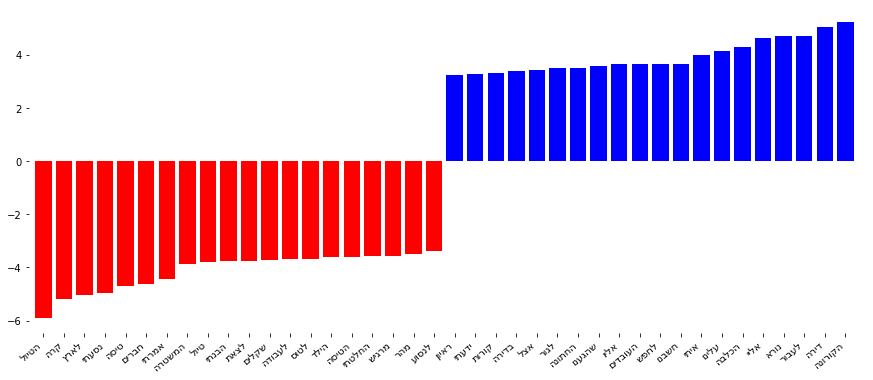

In [32]:
def plot_important_features(coef, feature_names, top_n=20, ax=None, rotation=60):
    if ax is None:
        ax = plt.gca()
    inds = np.argsort(coef)
    low = inds[:top_n]
    high = inds[-top_n:]
    important = np.hstack([low, high])
    myrange = range(len(important))
    colors = ['red'] * top_n + ['blue'] * top_n
    
    ax.bar(myrange, coef[important], color=colors)
    ax.set_xticks(myrange)
    heb_feature_names =[bidialg.get_display(feature) for feature in feature_names[important]]
    ax.set_xticklabels(heb_feature_names, rotation=rotation, ha="right")
    ax.set_xlim(-.7, 2 * top_n)
    ax.set_frame_on(False)

    
vect = CountVectorizer(min_df=4, stop_words=stop_words)
X_train = vect.fit_transform(X)
X_train = normalize(X_train,norm="l1")

sgdc = SGDClassifier()
sgdc.fit(X_train, Y)
    
plt.figure(figsize=(15, 6))
plot_important_features(sgdc.coef_.ravel(), np.array(vect.get_feature_names()), top_n=20, rotation=40)
ax = plt.gca()
plt.show()

### GENSIM

In [33]:
%pip install --upgrade gensim

Requirement already up-to-date: gensim in /opt/anaconda3/lib/python3.8/site-packages (4.0.1)
Note: you may need to restart the kernel to use updated packages.


In [34]:
import gensim

/opt/anaconda3/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [35]:
def read_corpus(text, tokens_only=False):
    for i, line in enumerate(text):
        if tokens_only:
            yield gensim.utils.simple_preprocess(line)
        else:
            # For training data, add tags
            yield gensim.models.doc2vec.TaggedDocument(
                gensim.utils.simple_preprocess(line), [i])


            
train_corpus = list(read_corpus(df_train['narrative']))
test_corpus = list(read_corpus(df_test['narrative'], tokens_only=True))

model = gensim.models.doc2vec.Doc2Vec(vector_size=50, min_count=2)
model.build_vocab(train_corpus)

model.train(train_corpus, total_examples=model.corpus_count, epochs=55)

vectors = [model.infer_vector(train_corpus[doc_id].words)
          for doc_id in range(len(train_corpus))]

X_train = np.vstack(vectors)

X_train.shape

(408, 50)

In [36]:
for regr in get_regressors():
    get_cross_val_score(scores_df,regr, X_train, Y,"gensim")


*********LogisticRegression *********
*********LogisticRegressionCV *********
*********PassiveAggressiveClassifier *********
*********Perceptron *********
*********RidgeClassifier *********
*********RidgeClassifierCV *********
*********SGDClassifier *********


In [37]:
display(scores_df.sort_values(by="f1",ascending=False).head(5))

,f1,recall,roc_auc,average_precision
SGDClassifier_CountVectorizer_ngram_normalize,0.643670,0.755952,0.622976,0.637472
SGDClassifier_TfidfVectorizer_normalized,0.629095,0.757619,0.620095,0.639043
SGDClassifier_CountVectorizer_normalized,0.626824,0.706905,0.624131,0.639467
Perceptron_CountVectorizer_ngram_normalize,0.604797,0.680714,0.590190,0.618131
LogisticRegressionCV_CountVectorizer_normalized,0.593541,0.597857,0.617690,0.641610


### BoW + embedding

In [38]:
vect = CountVectorizer(min_df=4, stop_words=stop_words)
X_train = vect.fit_transform(X)
X_train = normalize(X_train,norm="l1")


train_corpus = list(read_corpus(df_train['narrative']))

doc2vec = gensim.models.doc2vec.Doc2Vec(vector_size=50, min_count=2)
doc2vec.build_vocab(train_corpus)

doc2vec.train(train_corpus, total_examples=doc2vec.corpus_count, epochs=55)

vectors = [doc2vec.infer_vector(train_corpus[doc_id].words)
          for doc_id in range(len(train_corpus))]

X_train_d2v = np.vstack(vectors)
X_train_d2v.shape

X_bow_array = X_train.toarray()
X_train_bow_d2v = np.concatenate((X_bow_array,X_train_d2v),axis=1)

In [39]:
for regr in get_regressors():
    get_cross_val_score(scores_df,regr, X_train_bow_d2v, Y,"bow_d2vec")


*********LogisticRegression *********
*********LogisticRegressionCV *********
*********PassiveAggressiveClassifier *********
*********Perceptron *********
*********RidgeClassifier *********
*********RidgeClassifierCV *********
*********SGDClassifier *********


In [40]:
display(scores_df.sort_values(by="f1",ascending=False).head(5))

,f1,recall,roc_auc,average_precision
SGDClassifier_CountVectorizer_ngram_normalize,0.643670,0.755952,0.622976,0.637472
SGDClassifier_TfidfVectorizer_normalized,0.629095,0.757619,0.620095,0.639043
SGDClassifier_CountVectorizer_normalized,0.626824,0.706905,0.624131,0.639467
Perceptron_CountVectorizer_ngram_normalize,0.604797,0.680714,0.590190,0.618131
LogisticRegressionCV_CountVectorizer_normalized,0.593541,0.597857,0.617690,0.641610


### hebrew_tokenizer

Let's try to tokenize texts and see if can extract some usefule information from that, such as: how many time date or hour was mentioned, how many puntuation marks, etc...

In [41]:
%pip install hebrew_tokenizer
import hebrew_tokenizer as ht

tokens = ht.tokenize(df_train['narrative'])

Note: you may need to restart the kernel to use updated packages.
/Users/alexanderkruglyak/study/master-of-science/semester_2/Advanced_Topics_in_Machine_Learning/final_assigment_sasha


/opt/anaconda3/lib/python3.8/site-packages/hebrew_tokenizer/tokenizer.py:121: FutureWarning: Possible nested set at position 729
  self.scanner = re.compile(


In [42]:
for (index, t) in enumerate(df_train['narrative'].tolist()):
    tokens = ht.tokenize(t)
    for grp, token, token_num, (start_index, end_index) in tokens:
        if grp not in df_train:
            df_train[grp] = [0] * len(df_train)
            df_train[grp][index] = 1
        else:
            df_train[grp][index] += 1

<ipython-input-42-3018e22d4d26>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[grp][index] = 1
<ipython-input-42-3018e22d4d26>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[grp][index] += 1


In [43]:
df_train

,author_birth_year,narrative,label,author_gender_female,author_gender_male,HEBREW,NUMBER,PUNCTUATION,ENGLISH,HOUR,DATE
0,1995,"שנת 2020 הייתה מטלטלת למדי בשבילי, עברתי הרבה ...",1,0,1,331,1,27,0,0,0
1,1992,בשנת 2018 קיבלתי החלטה שאני מתחיל ללמוד לתואר ...,1,0,1,292,7,26,3,0,0
2,1992,לפני מספר שנים אני ובת הזוג שלי טסנו ללונדון ז...,1,0,1,375,3,8,0,0,0
3,1991,"האישה שבקושי הכרתי חייכה תמיד, העיניים שלה ברק...",1,1,0,307,0,49,0,0,0
4,1992,בדרך חזרה מהטיול שנתי בכיתה ח' התקשרתי לאבא של...,1,1,0,301,0,24,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
403,1988,"ללמוד להעז יותר, אחד החוויה הזאת שעשיתי באה אח...",0,0,1,470,18,63,0,0,0
404,1993,זה קרה לפניי מספר שבועות עוד כשהיינו תחת סגרים...,0,0,1,310,0,36,0,0,0
405,1995,"לפני שלוש שנים, לאחר שחסכתי, טסתי עם חבר מאוד ...",0,0,1,347,2,64,0,0,0
406,1993,כשהייתי ילדה קטנה בבית הספר בגיל 8 הייי ילדה מ...,0,1,0,280,1,5,0,0,0


## Linear models on numerical data

In [44]:
def add_linear_score(scores_df, score, regressorName, dataType):
    scores_df.loc[regressorName + '_' + dataType, 'r2'] = np.mean(score)
    
def get_cross_val_score_linear(scores_df,estimator,X_train,y_train,prefix="",sampler=None):
        name = estimator.__class__.__name__
        if estimator.__class__ is Pipeline:
            name = estimator.named_steps['estimator'].__class__.__name__
        pipe = estimator
        sampler_name = ""
        if sampler is not None:
            pipe = make_imb_pipeline(sampler(random_state=42), estimator)
            sampler_name = sampler.__name__
        print('*********' + name + ' ' + sampler_name + '*********')
        score = cross_val_score(
            pipe,
            X_train, 
            y_train, 
            cv=10,
            scoring=('r2'),
            n_jobs = -1
        )
        add_linear_score(scores_df, score, name,prefix)
        
def get_continuous_features(df):
    return df.select_dtypes(exclude=['object'])

In [45]:
scores_df = pd.DataFrame(dtype=float)

X_num = get_continuous_features(df_train)
X,Y = get_label_and_drop(X_num)


In [46]:
for regr in get_regressors():
    get_cross_val_score_linear(scores_df, regr, X, Y, "numerical")

scores_df

*********LogisticRegression *********
*********LogisticRegressionCV *********
*********PassiveAggressiveClassifier *********
*********Perceptron *********
*********RidgeClassifier *********
*********RidgeClassifierCV *********
*********SGDClassifier *********


,r2
LogisticRegression_numerical,-1.010714
LogisticRegressionCV_numerical,-0.981190
PassiveAggressiveClassifier_numerical,-0.991190
Perceptron_numerical,-0.991190
RidgeClassifier_numerical,-1.000952
RidgeClassifierCV_numerical,-1.010952
SGDClassifier_numerical,-1.010714


### Text feature + non text features

In [47]:
def get_num_text_pipeline(df,regr_num,regr_text):
    numeric_cols = df.columns[df.columns.dtype != object].tolist()
    
    transformer_text = FunctionTransformer(lambda x: x['narrative'], validate=False)
    transfomer_numeric = FunctionTransformer(lambda x: x[numeric_cols], validate=False)

    pipeline = Pipeline([
        ('features', FeatureUnion([
                ('numeric_features', Pipeline([
                    ('selector', transfomer_numeric)
                ])),
                 ('text_features', Pipeline([
                    ('selector', transformer_text),
                    (regr_text.__class__.__name__, regr_text)
                ]))
             ])),
        ('estimator', regr_num)
    ])
    return pipeline

In [48]:
X,Y = get_label_and_drop(df_train)
scores_df = pd.DataFrame(dtype=float)
vect = CountVectorizer(min_df=4, stop_words=stop_words)

for regr in get_regressors():
    pipe = get_num_text_pipeline(X, regr, vect)
    get_cross_val_score(scores_df, pipe, X, Y, vect.__class__.__name__ + "_combined_" + regr.__class__.__name__)


*********Pipeline *********
*********Pipeline *********
*********Pipeline *********
*********Pipeline *********
*********Pipeline *********
*********Pipeline *********
*********Pipeline *********


In [49]:
display(scores_df.sort_values(by="f1",ascending=False).head(5))

,f1,recall,roc_auc,average_precision
Pipeline_CountVectorizer_combined_RidgeClassifierCV,0.553676,0.563810,0.578190,0.602499
Pipeline_CountVectorizer_combined_LogisticRegressionCV,0.551953,0.544762,0.611738,0.612441
Pipeline_CountVectorizer_combined_LogisticRegression,0.549076,0.554048,0.585167,0.610382
Pipeline_CountVectorizer_combined_RidgeClassifier,0.546479,0.559286,0.556321,0.589931
Pipeline_CountVectorizer_combined_PassiveAggressiveClassifier,0.544977,0.564048,0.568560,0.601904


### Conculion
It seems that tokenizing text do not provide any significant impact on our model

# Run best model on test data

We will use ngram normalized **CountVectorizer** with **SGDClassifier**

In [64]:
X = df_train['narrative'].tolist()
Y = df_train['label']

X_test = df_test['narrative'].tolist()

ngrm = CountVectorizer(min_df=4, stop_words=stop_words, ngram_range=(1, 3))

X_train = ngrm.fit_transform(X)
X_test = ngrm.transform(X_test)

X_train = normalize(X_train,norm="l1")
X_test = normalize(X_test, norm="l1")

classifier = SGDClassifier()
classifier.fit(X_train, Y)

result = classifier.predict(X_test)

In [66]:
result_df = pd.DataFrame({ "label": result })

In [67]:
result_df

,label
0,0
1,1
2,1
3,1
4,0
...,...
101,0
102,1
103,1
104,0


In [69]:
result_df.to_csv('323637736.csv', index=False)